# Micromagnetic Simulation for Transition-Metal-Induced Uniaxial Anisotropy in Fe<sub>3</sub>Y Using Ab Initio Results
The simulation is run using <a href=https://mammos-project.github.io/>mammos-mumag</a> package and Ab Initio results published on <a href="https://nomad-lab.eu/prod/v1/gui/search/entries/entry/id/IKz8YoFNv2Fx6KO3SwGtcDANU4RS/files/_mainfile">NOMAD</a>.

In order to run the simulation one needs to download one/all of the following files:
* Fe2.33Nb0.67Y.h5
* Fe2.33Ta0.67Y.h5
* Fe2.33V0.67Y.h5
* Fe2.33Zn0.67Y.h5

## Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import zipfile
import os
import pandas as pd
import h5py
import data_process_functions as dpf
from functools import partial
from scipy.optimize import curve_fit
from scipy.constants import physical_constants
from scipy.constants import mu_0
import mammos_units as u
import mammos_entity as me

# Set unit equivalencies to be able to work with magnetic flux density (T)
u.set_enabled_equivalencies(u.magnetic_flux_field())


## Setting up parameters and file names

In [2]:
# Set parameters
element = 'Ta'

# Generate filenames and simulation names
h5_filename = f'h5_files/Fe2.33{element}0.67Y.h5' #'Fe16N2.h5'
simulation_name = f'Fe233{element}67Y100'
kuz_plot_filename = f'pics/Kuzmin_fit_{simulation_name}.pdf'
csv_filename = f'pics/results_{simulation_name}.csv'
h5_filename


'h5_files/Fe2.33Ta0.67Y.h5'

## Kuz'min fit to get 

In [3]:
# Extract data from H5 file
M_T_data = dpf.get_M_T_data_from_h5(h5_filename)
n_atoms = dpf.get_n_atoms_per_cell_from_h5(h5_filename)
ucvA = dpf.get_unit_cell_volume_h5(h5_filename)
xyz_dirs = h5py.File(h5_filename, 'r')['raw_data/GS']
K1_in_JPerCubibm = dpf.compute_anisotropy_constant_h5(xyz_dirs, ucvA)
# M_T_data

/ceph/home/pile/mammos/mammos-pixi-test/examples/Fe3Y/Notebook/data_process_functions.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  M_T_data = pd.concat([M_T_data, pd.DataFrame([[float(x) for x in item.split(sep=' ')]], columns=columns)], ignore_index=True)


[ 10.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500. 520. 540.
 560. 580. 600. 620. 640. 660. 680. 700. 720. 740. 760. 780. 800.]
Number of atoms: 21
Simulation name: Fe233Ta67Y100
Tc = 560.0 K
0.6723312723322679 2.125207331063916
Spin wave stiffness constant  1.5609533445866293e-40
Exchange constant A at T=0 (J/m) :  2.2513126755913614e-12
Js_300 (T):  0.49663623969907034
A_300 (J/m):  1.2284175322222823e-12
K_300 (J/m^3):  876234.6199878985
Tc = 560.0 K
0.6723312723322679 2.125207331063916
Spin wave stiffness constant  1.5609533445866293e-40
Exchange constant A at T=0 (J/m) :  2.2513126755913614e-12
Js_450 (T):  0.33203632016157697
A_450 (J/m):  5.490860071978506e-13
K_450 (J/m^3):  261855.65871432674
Lex  2.5017247670145077


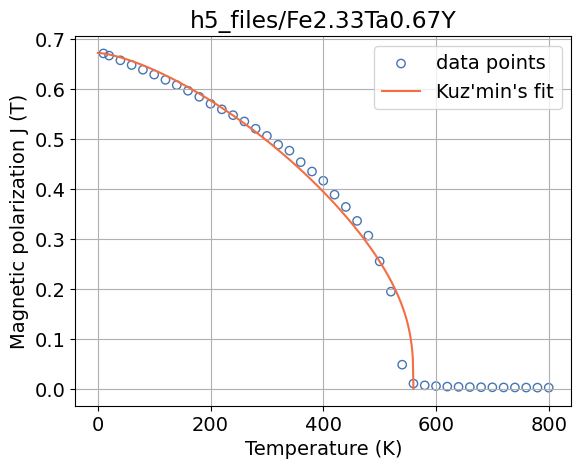

In [4]:
# Extract temperature and magnetization data
TK = M_T_data['T'].to_numpy()
Js = M_T_data['M'].to_numpy()
print(TK)

print(f"Number of atoms: {n_atoms}")

# Convert magnetization to magnetic polarization in Tesla
Js = [item * n_atoms / ucvA * 11.654 for item in Js]

print(f'Simulation name: Fe233{element}67Y100')

# Fit Kuzmin model to get A and K at 300K and 450K
Js_300, A_300, K_300, xfine, Js_0, s, m_s = dpf.Kuzmin_fit(TK, Js, 300, K1_in_JPerCubibm)
Js_450, A_450, K_450, xfine, Js_0, s, m_s = dpf.Kuzmin_fit(TK, Js, 450, K1_in_JPerCubibm)

# Create results DataFrame
df_results = pd.DataFrame({
    'Simulation name': simulation_name, 
    'Js_300 (T)':[Js_300], 
    'A_300 (J/m)':[A_300], 
    'K_300 (J/m^3)':[K_300], 
    'Js_450 (T)':[Js_450], 
    'A_450 (J/m)':[A_450], 
    'K_450 (J/m^3)':[K_450]})

# exchange length in nm
print("Lex ", np.sqrt(mu_0 * A_300 / (Js_300 * Js_300)) / 1e-9)

plot_Js = True

# Plot Kuzmin fit
if plot_Js:
    fig, ax = plt.subplots()
    ax.scatter(
        TK,
        Js,
        marker="o",
        label="data points",
        facecolors="none",
        edgecolors="#4575b4",
    )
    label = "Kuz'min's fit"
    ax.plot(xfine, m_s(xfine, Js_0, s), label=label, color="#f46d43")
    ax.legend()
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Magnetic polarization J (T)")
    ax.grid()
    ax.set_title(h5_filename[:-3])
    # If you want to save the figure, uncomment the line below
    # fig.savefig(kuz_plot_filename, dpi=300)

# If you want to save the results to a CSV file, uncomment the line below
# df_results.to_csv(csv_filename, index=False)

In [5]:
df_results

,Simulation name,Js_300 (T),A_300 (J/m),K_300 (J/m^3),Js_450 (T),A_450 (J/m),K_450 (J/m^3)
0,Fe233Ta67Y100,0.496636,1.228418e-12,876234.619988,0.332036,5.490860e-13,261855.658714


In [6]:
# Calculate single domain limit
A = me.A(A_300)
J_s = me.Js(Js_300)
mu_0_u = mu_0 * u.H / u.m
M_s = J_s.q.to('A/m')
K_m = 0.5 * M_s**2 * mu_0_u
l_ex = (A / K_m)**0.5
print('Single domain limit (cube): ', l_ex.to('nm') * 8.51)
print('Single domain limit (sphere): ', l_ex.to('nm') * 10.2)


Single domain limit (cube):  30.108151057424767 nm
Single domain limit (sphere):  36.08732559174296 nm


## Micromagnetic simulation

In [7]:
from mammos_mumag import hysteresis
from mammos_mumag.materials import Materials
from mammos_mumag.parameters import Parameters
from mammos_mumag.simulation import Simulation
import numpy as np
import sys

# Input parameters BEGIN
K_300_sim = K_300 * u.J / u.m**3
Js_300_sim = Js_300 * u.T
K_450_sim = K_450 * u.J / u.m**3
Js_450_sim = Js_450 * u.T
fileName = simulation_name
N_air = 3 # 2 if no intergranular phase, 3 if there is an intergranular phase
# Input parameters END

u.set_enabled_equivalencies(u.magnetic_flux_field())

In [8]:
meshes = [
    'cube40_equi_grains8_gsize20', 
    # If you want to run simulations for several sizes and mesh types, uncomment the lines below
    # 'cube80_equi_grains8_gsize40', 
    # 'cube160_equi_grains8_gsize80', 
    # 'cube40_colu_grains8_gsize20', 
    # 'cube80_colu_grains8_gsize40', 
    # 'cube160_colu_grains8_gsize80', 
    # 'cube40_3plat_grains12_gsize20', 
    # 'cube80_3plat_grains12_gsize40', 
    # 'cube160_3plat_grains12_gsize80'
    ]
meshes

['cube40_equi_grains8_gsize20']

### Simulation at 300 K

In [ ]:
for mesh in meshes:
    print(f"mesh: {mesh}")
    
    # --- Parameters ---
    # Extract number of grains from mesh name. If your mesh naming convention is different, modify this line accordingly.
    N_grains = int(mesh[mesh.find('grains')+len('grains'):mesh.find('_gsize')])
    print(f'number of grains: {N_grains}')
    sigma = 20.*np.pi/180. # Sigma in radians
    
    theta, phi = dpf.theta_phi(N_grains, sigma)
    
    mat = Materials()
    
    Hani = 2 * K_300_sim / Js_300_sim
    Hmax = round(2 * Hani.to("T"), 2)
    Ms_300 = Js_300_sim.to("A/m")
    
    # Material parameters for
    # Grains'
    for i in range(N_grains):
        mat.add_domain(
            A = A_300,
            Ms = Ms_300.value,
            K1 = K_300_sim.value,
            K2 = 0,
            phi = phi[i],
            theta = theta[i]
    )
    
    # Intergranular phase / air
    for i in range(N_air):
        mat.add_domain(
            A = 0,
            Ms = 0,
            K1 = 0,
            K2 = 0,
            phi = 0,
            theta = 0
    )
    
    # Simulation parameters
    par = Parameters(
        size=1.0e-9,
        scale=0,
        m_vect=[0, 0, 1],
        h_start=Hmax.to("A/m"),
        h_final=-Hmax.to("A/m"),
        h_step=(-0.01 * u.T).to("A/m"),
        h_vect=[0, 0, 1],
        m_step=(0.4 * u.T).to("A/m"),
        m_final=(-2 * u.T).to("A/m"),
        tol_fun=1e-10,
        tol_h_mag_factor=1,
        precond_iter=10,
    )
    
    sim = Simulation(
        mesh=mesh,
        materials=mat,
        parameters=par,
    )

    print('running p1: Hmax to -Hmax')
    sim.run_loop(outdir=mesh+'_p1', name=fileName)

mesh: cube40_equi_grains8_gsize20
number of grains: 8
running p1: Hmax to -Hmax


### Simulation at 450 K

In [ ]:
for mesh in meshes:
    print(f"mesh: {mesh}")
    
    # --- Parameters ---
    # Extract number of grains from mesh name. If your mesh naming convention is different, modify this line accordingly.
    N_grains = int(mesh[mesh.find('grains')+len('grains'):mesh.find('_gsize')])
    print(f'number of grains: {N_grains}')
    sigma = 20.*np.pi/180. # Sigma in radians
    
    theta, phi = dpf.theta_phi(N_grains, sigma)
    
    mat = Materials()
    
    Hani = 2 * K_450_sim / Js_450_sim
    Hmax = round(2 * Hani.to("T"), 2)
    Ms_450 = Js_450_sim.to("A/m")
    
    # Material parameters for
    # Grains'
    for i in range(N_grains):
        mat.add_domain(
            A = A_450,
            Ms = Ms_450.value,
            K1 = K_450_sim.value,
            K2 = 0,
            phi = phi[i],
            theta = theta[i]
    )
    
    # Intergranular phase / air
    for i in range(N_air):
        mat.add_domain(
            A = 0,
            Ms = 0,
            K1 = 0,
            K2 = 0,
            phi = 0,
            theta = 0
    )
    
    # Simulation parameters
    par = Parameters(
        size=1.0e-9,
        scale=0,
        m_vect=[0, 0, 1],
        h_start=Hmax.to("A/m"),
        h_final=-Hmax.to("A/m"),
        h_step=(-0.01 * u.T).to("A/m"),
        h_vect=[0, 0, 1],
        m_step=(0.4 * u.T).to("A/m"),
        m_final=(-2 * u.T).to("A/m"),
        tol_fun=1e-10,
        tol_h_mag_factor=1,
        precond_iter=10,
    )
    
    sim = Simulation(
        mesh=mesh,
        materials=mat,
        parameters=par,
    )

    print('running p1: Hmax to -Hmax')
    sim.run_loop(outdir=mesh+'_p1', name=fileName)